# Deep Neural Network - Actual model
(Baseline model in other file)

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedShuffleSplit
import statistics
from oversampling import one_hot, smote_loop

from tqdm import tqdm
from IPython.display import display

from data_processing import prepare_data, split_data
from helper_functions import get_metrics

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, Input, metrics, initializers
from tensorflow.keras.metrics import FalsePositives, TruePositives, FalseNegatives, TrueNegatives

from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix


In [2]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv')
#data.replace({0: -1})
# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

### Milestone 2: Actual model
##### Additions:
1. Class weights to increase sensitivity to stroke cases. 
2. More metrics added (sensitivity and specificity)
3. Cross-validation applied with stratification of the splits
4. Evaluation of effect of class weights on different metrics, using cross-validation.

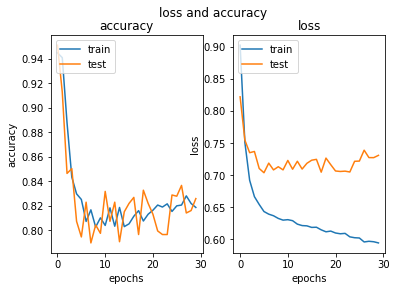

train metrics: 

accuracy: 83.1648 % 

balanced accuracy: 78.4153 %
sensitivity: 0.7315
specificity: 0.8368 

confusion matrix: 
[[2440  476]
 [  40  109]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 

test metrics: 

accuracy: 82.5832 % 

balanced accuracy: 70.9239 %
sensitivity: 0.5800
specificity: 0.8385 

confusion matrix: 
[[815 157]
 [ 21  29]] 

[["True Negative", "False Positive"] 
 ["False Negative", "True Positive"]] 



In [3]:
# Actual model

def train_and_predict(model, training_data, training_labels, 
                      testing_data, testing_labels, epochs=5, 
                      class_weight=10, verbose=0, plot=True):
    """
    This function trains a given neural network model based on training data and training labels. It then predicts classes on
    training and testing data. 
    It is possible to adjust for how many epochs the model is trained and how to weight the sparse class.
    
    input:
    
    model:        model architecture defined before calling this function
    class_weight:  errors on the stroke class should be weighted heavier then the non-stroke class. 
                  The value defines how much more this loss is weighted. loss_weight=10 means a ratio of 1 to 10.
                  For some reason
    verbose:      0: no text per epoch
                  1: text for each epoch
    plot:         True: show accuracy and loss over epochs in figure
                  False: no plot
                  
    output: 
    
    predictions_train: vector of training predictions
    predictions_test:  vector of test predictions
    history:           dict containing measures over epochs, including loss, accuracy, TP, FP, TN, FN, for train and test data.
                       print history.history for all measures and their keys.
    
    """
   
    # Compile the layers of the model defined earlier. Use the binary cross entropy function as the loss function as we only
    # have 2 output classes and use accuracy as the metric
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    
    # set warnings off (annoying bug in tensorflow)
    tf.get_logger().setLevel('ERROR')
    # Train the model for a number of epochs
    history = model.fit(training_data, training_labels, epochs=epochs, 
                        validation_data=(testing_data, testing_labels),
                        class_weight=[{0: 1., 1: class_weight}],
                        #sample_weight=[None],
                        verbose=verbose
                       )
    # set warnings on again 
    tf.get_logger().setLevel('INFO')

    # Predict the classes of the training data
    predictions_train = model.predict(training_data) >= 0.5
    
    # Predict the classes on the testing data
    predictions_test = model.predict(testing_data) >= 0.5
    
    # Plot the loss and accuracy over epochs.
    if plot:
        fig, axs = plt.subplots(1, 2)
        fig.suptitle('loss and accuracy')
    
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].legend(['train', 'test'], loc='upper left')
        axs[0].set_title('accuracy')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epochs')


        # Plot the loss over epochs
        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title('loss')
        axs[1].set_xlabel('epochs')
        axs[1].set_ylabel('loss')
        axs[1].legend(['train', 'test'], loc='upper left')

    
    plt.show()

    return predictions_train, predictions_test, history


def get_model():
    # Get the amount of input features for the nodes in the first layer
    input_shape = np.shape(train_data)[1]

    # Create the model
    initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=12345)
    model = models.Sequential()

    # First layer with input nodes equal to features
    model.add(Input(shape=(input_shape)))

    # One hidden layer with 25 nodes
    model.add(layers.Dense(25, activation='relu', kernel_initializer=initializer))

    model.add(layers.Dense(10, activation='relu', kernel_initializer=initializer))

    # Output layer with 1 node (only 1 output class, 0 or 1 for stroke) and sigmoid activation function
    model.add(layers.Dense(1, 'sigmoid'))

    return model

model = get_model()

# Train and predict
predictions_train, predictions_test, history = train_and_predict(model, train_data, 
                                                        train_labels, test_data, test_labels,
                                                        class_weight = 10,
                                                        epochs=30, verbose=0)

# Print metrics
print('train metrics: \n')
accuracy_train, balanced_accuracy_train = get_metrics(train_labels, predictions_train, verbose=True)

print('test metrics: \n')
accuracy_test, balanced_accuracy_test = get_metrics(test_labels, predictions_test, verbose=True)



### Parameter optimization

##### Class weights

The code below performs training and validation of the DNN model using different class weights.
The different output metrics are then plotted as a function of the class weights to evaluate the weighting effect.

100%|██████████| 15/15 [00:49<00:00,  3.30s/it]


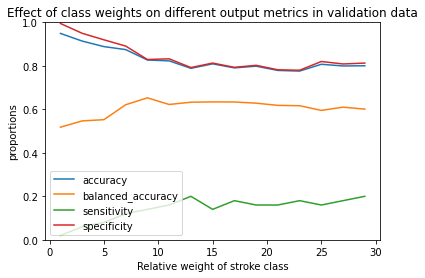

In [4]:
# Test different class weights and plot accuracy and sensitivity

accuracies_val = []
sensitivities_val = []
balanced_accuracies_val = []
specificities_val = []

for i in tqdm(range(1, 30, 2)):
    
    # Train and predict
    predictions_train, predictions_val, history = train_and_predict(model, train_data, 
                                                          train_labels, val_data, val_labels,
                                                          epochs=30, verbose=0, plot=False,
                                                          class_weight=i)
    
    # metrics
    accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)
    conmat = confusion_matrix(test_labels, predictions_val)
    sensitivity = conmat[1,1] / sum(conmat[1,:])
    specificity = conmat[0,0] / sum(conmat[0,:])

    accuracies_val.append(accuracy_val)
    balanced_accuracies_val.append(balanced_accuracy_val)
    sensitivities_val.append(sensitivity)
    specificities_val.append(specificity)
    
## Plot metrics over  class weights.

plt.plot(range(1,30,2), accuracies_val)
plt.plot(range(1,30,2), balanced_accuracies_val)
plt.plot(range(1,30,2), sensitivities_val)
plt.plot(range(1,30,2), specificities_val)
plt.ylim(0, 1)
plt.title('Effect of class weights on different output metrics in validation data')
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
plt.show()  


    


In [7]:
# Get the data and clean it
data = prepare_data('healthcare-dataset-stroke-data.csv', one_hot = False, binary = True, normalize = True)

#data.replace({0: -1})
# Split the data into test, training and validation data
train_data, test_data, val_data, train_labels, test_labels, val_labels = split_data(data, split_size=(0.6, 0.2, 0.2))

In [9]:
# Tryout with different oversampling ratios

oversampling_val = []
oversampling_val_bal = []

# Define categorial features
n_features = np.array([True, False, True, True, True, True,True, False, False, True])

print(train_data)

list_data, list_labels, list_ratio = smote_loop(train_data, train_labels, n_features, 0.2, 1.01, 0.2)

for data_res, labels_res in zip(list_data, list_labels):
    
    # Train and predict
    predictions_train, predictions_val, history = train_and_predict(model, data_res, 
                                                          labels_res, val_data, val_labels,
                                                          epochs=30, verbose=0, plot=False,
                                                          class_weight=[{0: 1., 1: 10}])
    
    # metrics
    accuracy_val, balanced_accuracy_val = get_metrics(val_labels, predictions_val, verbose=False)

    oversampling_val.append(accuracy_val)
    oversampling_val_bal.append(balanced_accuracy_val)
    
## Plot metrics over  class weights.

plt.plot(np.linspace(0.2, 1, 5), accuracies_val)
plt.plot(np.linspace(0.2, 1, 5), balanced_accuracies_val)

plt.ylim(0, 1)
plt.title('Effect of class weights on different output metrics in validation data')
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy'])
plt.show()  



      gender       age  hypertension  heart_disease  ever_married  \
1921       1  0.034054             0              0             1   
722        1 -1.513840             0              0             0   
4805       0 -0.275525             0              0             1   
4091       0 -0.717780             0              0             0   
1237       0 -0.452427             0              0             1   
...      ...       ...           ...            ...           ...   
2753       0 -1.115810             0              0             0   
1134       1 -1.842878             0              0             0   
2377       0 -0.673555             0              0             1   
1458       0  0.299408             1              0             1   
4196       0 -1.779193             0              0             0   

          work_type  residence_type  avg_glucose_level       bmi  \
1921        Private               0          -0.235872  0.324124   
722        children               0

ValueError: Error when checking input: expected input_1 to have shape (16,) but got array with shape (19,)

### k-fold cross-validation

In [136]:
def k_fold_validation(X, y, k=5, class_weight=10, epochs=5, to_return=['metrics', 'history']):
    """
    Uses k-fold cross-validation to estimate average training and validation accuracies over different splits.
    Uses all training/validation data and resplits it 5 times into a training and validation set.
    Then performs training and testing of the model and takes average of accuracies over all 5 folds.
    
    input:
    X:              data array containing all features of training and validation data for cross-validation
    y:              labels of X data
    k:              number of folds for cross-validation
    class_weight:   relative weight of stroke class cost for model training (ratio 1:class_weight)
    epochs:         number of epochs
    to_return:      list with either one or two strings:
                    'metrics': returns all relevant metrics after all epochs are finished, averaged over k splits
                    'history': returns the loss and accuracy of train and validation data after each epoch, 
                               averaged over k splits
    
    output:         optional: metrics, history (both tuples)
                    metrics: avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec
                    history: avg_loss_over_epochs, avg_acc_over_epochs, avg_loss_over_epochs_val, avg_acc_over_epochs_val
    
    """
    # ensure that something is returned, also if one of these will not be calculated.
    metrics = None
    history = None
    
    # initialize metrics
    if 'metrics' in to_return:
        accuracies_train = []
        balanced_accuracies_train = []
        accuracies_val = []
        balanced_accuracies_val = []
        sensitivities = []
        specificities = []
        histories = []
    
    # get object that splits the data in 5 equal stratified folds.
    sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)
    # loop over those 5 datasets
    for train_index, test_index in sss.split(X, y):
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        
        # Find the best fitting theta for this training set using the Normal equation
        predictions_train, predictions_val, history = train_and_predict(model, x_train, y_train, 
                                          x_val, y_val, epochs=epochs, 
                                          class_weight=class_weight, verbose=0, plot=False)
        

        if 'history' in to_return:
            # store history of each split
            histories.append(history)
        
        if 'metrics' in to_return:
            # get metrics for this split
            accuracy_train, balanced_accuracy_train = get_metrics(y_train, predictions_train, verbose=False)
            accuracy_val, balanced_accuracy_val = get_metrics(y_val, predictions_val, verbose=False)
            # get confusion matrix to calculate sensitivity and specificity.
            conmat = confusion_matrix(y_val, predictions_val)
            sensitivity = conmat[1,1] / sum(conmat[1,:])
            specificity = conmat[0,0] / sum(conmat[0,:])
            
            # store metrics for this split
            accuracies_train.append(accuracy_train)
            balanced_accuracies_train.append(balanced_accuracy_train)
            accuracies_val.append(accuracy_val)
            balanced_accuracies_val.append(balanced_accuracy_val)
            sensitivities.append(sensitivity)
            specificities.append(specificity)
    

    if 'metrics' in to_return:
        # run over all metrics and compute and store their mean over all k splits.
        metrics_all = [accuracies_train, balanced_accuracies_train, accuracies_val, 
                       specificities, balanced_accuracies_val, sensitivities]
        metrics = []
        for metric in metrics_all:
            # compute average metrics over all k splits.
            metrics.append(statistics.mean(metric))
        metrics = tuple(metrics)

    if 'history' in to_return:
        history_metrics = []
        history_metrics_names = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
        for metric in history_metrics_names:
            # compute average loss and accuracy over all k splits for each epoch
            metric_history = np.zeros(len(history.history[metric]))
        
            # loop over the history dictionaries for each k split.
            for i in histories:
                metric_history = metric_history + np.array(i.history[metric])
                # add up data of each split for the loss and accuracy 
                # training data     
                
            history_metrics.append(metric_history / k)
        history = tuple(history_metrics)
    return metrics, history_metrics
    

# Datasets for k-fold cross-validation.
data = prepare_data('healthcare-dataset-stroke-data.csv')



# get cross-validation data (which will be further split into train and validation data), and test data.
X, test_data, y, test_labels = split_data(data, split_size=(0.8, 0.2))

# perform 5-fold cross-validation
epochs = 50
metrics, history = k_fold_validation(np.array(X), np.array(y), k=5, class_weight=15, epochs=epochs, to_return=['metrics','history'])

# unpack tuples
avg_loss_over_epochs, avg_acc_over_epochs, avg_loss_over_epochs_val, avg_acc_over_epochs_val = history
avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec = metrics

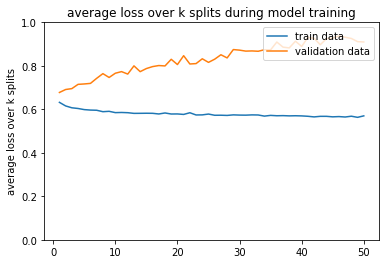

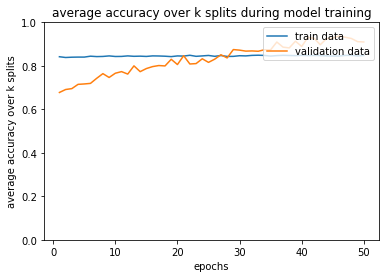

In [98]:
# plot the loss and accuracy during learning of the model, averaged over k splits using cross-validation
epochs = len(avg_loss_over_epochs)
plt.plot(range(1, epochs + 1), avg_loss_over_epochs)
plt.plot(range(1, epochs + 1), avg_loss_over_epochs_val)
plt.title('average loss over k splits during model training')
plt.ylabel('average loss over k splits')
plt.legend(['train data', 'validation data'], loc='upper right')
plt.ylim([0,1])
plt.show()

plt.plot(range(1, epochs + 1), avg_acc_over_epochs)
plt.plot(range(1, epochs + 1), avg_loss_over_epochs_val)
plt.title('average accuracy over k splits during model training')
plt.xlabel('epochs')
plt.ylabel('average accuracy over k splits')
plt.legend(['train data', 'validation data'], loc='upper right')
plt.ylim([0,1])
plt.show()

### Class weight effects on prediction metrics,  5-fold cross-validation applied.

In [135]:
# Datasets for k-fold cross-validation.
X = prepare_data('healthcare-dataset-stroke-data.csv')

# get cross-validation data (which will be further split into train and val data), and test data.
X, test_data, y, test_labels = split_data(data, split_size=(0.8, 0.2))

avg_accs = []
avg_accs_bal = []
avg_accs_val = []
avg_accs_bal_val = []
avg_sensitivities = []
avg_specificities = []

# do k-fold cross validation for different class weights
for i in tqdm(range(1, 30, 2)):
    metrics, history = k_fold_validation(np.array(X), np.array(y), k=5, 
                                         class_weight=i, epochs=5, to_return=['metrics', 'history'])

    # unpack metrics
    avg_acc_train, avg_bal_acc_train, avg_acc_val, avg_bal_acc_val, avg_sens, avg_spec = metrics

    avg_accs.append(avg_acc_train)
    avg_accs_bal.append(avg_bal_acc_train)
    avg_accs_val.append(avg_acc_val)
    avg_accs_bal_val.append(avg_bal_acc_val)
    avg_sensitivities.append(avg_sens)
    avg_specificities.append(avg_spec)
    
plt.title('Training data')
plt.plot(range(1, 30, 2), avg_accs)
plt.plot(range(1, 30, 2), avg_accs_bal)
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy'])
plt.show()

plt.title('Validation data')
plt.plot(range(1, 30, 2), avg_accs_val)
plt.plot(range(1, 30, 2), avg_accs_bal_val)
plt.plot(range(1, 30, 2), avg_sensitivities)
plt.plot(range(1, 30, 2), avg_specificities)
plt.ylabel('proportions')
plt.xlabel('Relative weight of stroke class')
plt.legend(['accuracy', 'balanced_accuracy', 'sensitivity', 'specificity'])
plt.show()

KeyError: 'stroke'